# Implementierung eines SNN und CNN: Ein Vergleich mit dem MNIST-Datensatz


*Author: Ümmühan Ay*

Schritt 1: Alle nötigen Imports importieren

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import time

Schritt 2: Cuda benutzen

In [2]:
device = torch.device("cuda")

Schritt 3: Implementierung des SNN und des LIF

In [3]:
class SNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.001, tau_plus=20.0, tau_minus=20.0, tau_mem=10.0, v_rest=-65.0, v_thresh=-50.0, v_reset=-65.0):
        super(SNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Synapsen-Gewichte initialisieren: (input_size, hidden_size)
        self.synapse_weights = nn.Parameter(torch.randn(input_size, hidden_size).to(device))
        self.fc2 = nn.Linear(hidden_size, output_size)

        self.learning_rate = learning_rate
        self.tau_plus = tau_plus
        self.tau_minus = tau_minus

        self.tau_mem = tau_mem  # Membranzeitkonstante
        self.v_rest = v_rest  # Ruhepotenzial
        self.v_thresh = v_thresh  # Schwellenwert
        self.v_reset = v_reset  # Reset-Potenzial

        # Membranpotentiale initialisieren
        self.v_hidden = torch.full((hidden_size,), self.v_rest, device="cuda")
        # STDP Zustände (Spuren für pre- und post-Spikes)
        self.pre_trace = torch.zeros(input_size, device="cuda")
        self.post_trace = torch.zeros(hidden_size, device="cuda")

    def forward(self, x, dt=1e-3):
        batch_size, time_steps, _ = x.shape
        spikes_out = torch.zeros(batch_size, time_steps, self.hidden_size, device=x.device)

        batch_size = x.shape[0]
        if self.v_hidden is None or self.v_hidden.shape[0] != batch_size:
            self.v_hidden = torch.full((batch_size, self.hidden_size), self.v_rest, device=x.device)

        for t in range(time_steps):
            z_pre = x[:, t, :]
            self.v_hidden = self.v_hidden + (self.v_rest - self.v_hidden) * (dt / self.tau_mem) + torch.matmul(z_pre, self.synapse_weights)
            z_post = (self.v_hidden > self.v_thresh).float()
            self.v_hidden = torch.where(z_post > 0, self.v_reset, self.v_hidden)
            spikes_out[:, t, :] = z_post
            #self.stdp_update(z_pre, z_post, dt)

        output = self.fc2(spikes_out.sum(dim=1))
        return output

    def stdp_update(self, z_pre, z_post, dt):
        self.pre_trace = (1 - dt / self.tau_plus) * self.pre_trace + z_pre.mean(dim=0)
        self.post_trace = (1 - dt / self.tau_minus) * self.post_trace + z_post.mean(dim=0)

        hebbian = torch.ger(self.post_trace, self.pre_trace)
        anti_hebbian = torch.ger(self.pre_trace, self.post_trace)

        dw = self.learning_rate * (hebbian - anti_hebbian.T)
        dw = torch.clamp(dw, -1.0, 1.0)
        self.synapse_weights.data += dw.T


Schritt 4: MNIST-Datensatz laden

Test mit MNIST

Test mit Kanji-Datensatz

In [4]:
from torch.utils.data import Subset

batch_size = 32
time_steps = 50


transform = transforms.Compose([
    transforms.ToTensor(),  # Bilder werden zu Tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalisierung für CIFAR-10
])

# CIFAR-10 Dataset laden (train und test)
train_dataset = datasets.CIFAR10(root='./cifar-10', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./cifar-10', train=False, download=False, transform=transform)
# Nur 900 Trainingsdaten & 100 Testdaten
train_subset = Subset(train_dataset, range(14000))
test_subset = Subset(test_dataset, range(1000))
# Trainings- und Test-Dataloader
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

def image_to_spikes(images, time_steps, threshold=0.5):
    # Setze threshold so, dass er mit den normalisierten Werten übereinstimmt
    spikes = torch.zeros((images.size(0), time_steps, images.size(1)), device=images.device)
    for t in range(time_steps):
        spikes[:, t, :] = (images > threshold).float()  # Generiere Spikes
    return spikes


Files already downloaded and verified


Schritt 5: CNN erstellen

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

        # Dropout nach der ersten Fully Connected Layer
        self.dropout = nn.Dropout(0.5)

        # BatchNorm für Convolutional Layer
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

    def forward(self, x):
        # Convolutional Layers mit BatchNorm und ReLU
        x = self.pool(F.relu(self.bn1(self.conv1(x))))   # 32x32 → 16x16
        x = self.pool(F.relu(self.bn2(self.conv2(x))))   # 16x16 → 8x8
        x = self.pool(F.relu(self.bn3(self.conv3(x))))   # 8x8 → 4x4
        
        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Fully Connected Layers mit Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Dropout nach fc1
        x = self.fc2(x)
        return x

6. Hyperparameter, Loss-Funktion und Optimizer definieren

In [ ]:
# Hyperparameter
input_size = 32 * 32 * 3
hidden_size = 512
output_size = 10
epochs = 100
time_steps = 50

snn_model = SNN(input_size=input_size, hidden_size=hidden_size, output_size=output_size).to(device)
cnn_model = SimpleCNN().to(device)

snn_optimizer = torch.optim.Adam(snn_model.parameters(), lr=0.001)
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

snn_loss_fn = torch.nn.CrossEntropyLoss()
cnn_loss_fn = torch.nn.CrossEntropyLoss()

In [7]:
start = time.time()

torch.cuda.reset_peak_memory_stats()
torch.cuda.synchronize()
start_memory = torch.cuda.memory_allocated()

7. Training SNN

In [8]:
# SNN trainieren
for epoch in range(epochs):
    snn_model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images = images.view(images.size(0), -1)
        images = images.to(device)
        labels = labels.to(device)
        spikes = image_to_spikes(images, time_steps)

        outputs = snn_model(spikes)
        loss = snn_loss_fn(outputs, labels.to(device))

        snn_optimizer.zero_grad()
        loss.backward()
        snn_optimizer.step()
        torch.cuda.empty_cache()

        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{epochs}], SNN Loss: {running_loss/len(train_loader):.4f}')

Epoch [1/20], SNN Loss: 5.4469
Epoch [2/20], SNN Loss: 3.2062
Epoch [3/20], SNN Loss: 2.9951
Epoch [4/20], SNN Loss: 3.0796
Epoch [5/20], SNN Loss: 2.9856
Epoch [6/20], SNN Loss: 2.9752
Epoch [7/20], SNN Loss: 2.9556
Epoch [8/20], SNN Loss: 2.9583
Epoch [9/20], SNN Loss: 3.0807
Epoch [10/20], SNN Loss: 2.9506
Epoch [11/20], SNN Loss: 2.9310
Epoch [12/20], SNN Loss: 2.9784
Epoch [13/20], SNN Loss: 3.0443
Epoch [14/20], SNN Loss: 3.0450
Epoch [15/20], SNN Loss: 2.9988
Epoch [16/20], SNN Loss: 2.9050
Epoch [17/20], SNN Loss: 2.9741
Epoch [18/20], SNN Loss: 3.0102
Epoch [19/20], SNN Loss: 2.9933
Epoch [20/20], SNN Loss: 2.9509


In [9]:
torch.cuda.synchronize()
end = time.time()
end_memory = torch.cuda.max_memory_allocated()

print(f"Trainingszeit: {end - start:.2f} Sekunden")
print(f"Maximale GPU-Speichernutzung: {end_memory / 1e6:.2f} MB")

Trainingszeit: 347.32 Sekunden
Maximale GPU-Speichernutzung: 8989.88 MB


8. CNN trainieren

In [10]:
scheduler = torch.optim.lr_scheduler.StepLR(cnn_optimizer, step_size=10, gamma=0.1)

for epoch in range(epochs):
    cnn_model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        cnn_optimizer.zero_grad()
        outputs = cnn_model(images)
        
        cnn_loss = cnn_loss_fn(outputs, labels)
        cnn_loss.backward()
        cnn_optimizer.step()
        torch.cuda.empty_cache()
        
        running_loss += cnn_loss.item()

    # Lernratenplaner verwenden
    scheduler.step()

    print(f'Epoch [{epoch+1}/{epochs}], CNN Loss: {running_loss/len(train_loader):.4f}')

Epoch [1/20], CNN Loss: 1.6602
Epoch [2/20], CNN Loss: 1.3346
Epoch [3/20], CNN Loss: 1.1842
Epoch [4/20], CNN Loss: 1.0735
Epoch [5/20], CNN Loss: 0.9752
Epoch [6/20], CNN Loss: 0.9046
Epoch [7/20], CNN Loss: 0.8173
Epoch [8/20], CNN Loss: 0.7592
Epoch [9/20], CNN Loss: 0.6801
Epoch [10/20], CNN Loss: 0.6263
Epoch [11/20], CNN Loss: 0.4652
Epoch [12/20], CNN Loss: 0.4139
Epoch [13/20], CNN Loss: 0.3907
Epoch [14/20], CNN Loss: 0.3707
Epoch [15/20], CNN Loss: 0.3549
Epoch [16/20], CNN Loss: 0.3412
Epoch [17/20], CNN Loss: 0.3303
Epoch [18/20], CNN Loss: 0.3190
Epoch [19/20], CNN Loss: 0.2971
Epoch [20/20], CNN Loss: 0.2939


In [11]:
torch.cuda.synchronize()
end = time.time()
end_memory = torch.cuda.max_memory_allocated()

print(f"Trainingszeit: {end - start:.2f} Sekunden")
print(f"Maximale GPU-Speichernutzung: {end_memory / 1e6:.2f} MB")

Trainingszeit: 445.83 Sekunden
Maximale GPU-Speichernutzung: 8989.88 MB


9. SNN Evaluieren

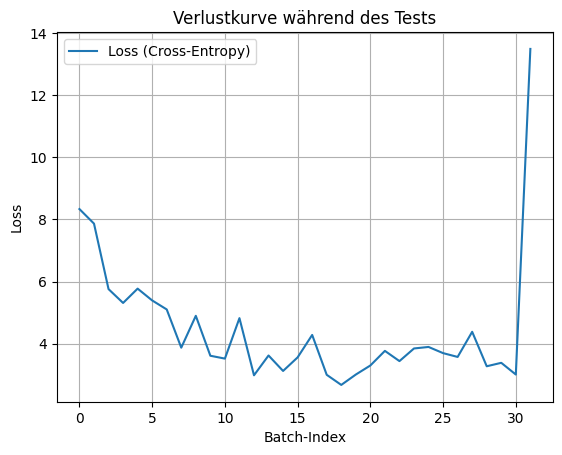

Accuracy (SNN): 17.10%


In [12]:
from matplotlib import pyplot as plt

snn_model.eval()
correct = 0
total = 0
loss_values = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(images.size(0), -1).to(device)
        spikes = image_to_spikes(images, time_steps)
        spikes = spikes.to(device)
        
        outputs = snn_model(spikes)
        loss = snn_loss_fn(outputs, labels.to(device))
        loss_values.append(loss.item())  # Speichern des Verlusts
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

# Plot der Verlustwerte
plt.plot(loss_values, label="Loss (Cross-Entropy)")
plt.xlabel("Batch-Index")
plt.ylabel("Loss")
plt.title("Verlustkurve während des Tests")
plt.legend()
plt.grid(True)
plt.show()

# Berechnung der Genauigkeit
accuracy = 100 * correct / total
print(f'Accuracy (SNN): {accuracy:.2f}%')


10. CNN Evaluieren

Accuracy (CNN): 71.80%


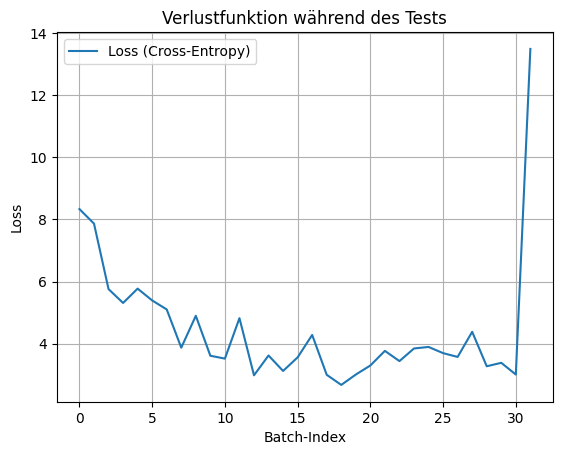

Accuracy (CNN): 71.80%


In [13]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy (CNN): {accuracy:.2f}%')


# Plot der Verlustkurve
plt.plot(loss_values, label="Loss (Cross-Entropy)")
plt.xlabel("Batch-Index")
plt.ylabel("Loss")
plt.title("Verlustfunktion während des Tests")
plt.legend()
plt.grid(True)
plt.show()

# Genauigkeit ausgeben
print(f'Accuracy (CNN): {100 * correct / total:.2f}%')
